In [1]:
%matplotlib inline

### Load the BPL simulation data

In [2]:
from diffprof.load_bpl_histories import load_histories
res = load_histories("/Users/aphearin/work/DATA/SIMS/BPl/full_trees", 'conc')
halo_ids, conch_sim, log_mahs, t_bpl, lgm_min = res
lgt_bpl = np.log10(t_bpl)
logmp = log_mahs[:, -1]

### Load the diffprof fits

In [3]:
import h5py
import os
from diffprof.load_diffprof_fits import impute_bad_concentration_fits
c_fits = dict()
c_fn = os.path.join("/Users/aphearin/work/DATA/diffprof_data", "bpl_cens_trunks_conc_fits_k4.0.h5")
with h5py.File(c_fn, "r") as hdf:
    for key in hdf.keys():
        c_fits[key] = hdf[key][...]
c_fits["conc_lgtc"] = impute_bad_concentration_fits(c_fits["conc_lgtc"])
print(c_fits.keys())

dict_keys(['conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'conc_loss', 'halo_id', 'method'])


### Compute the smooth concentration histories

In [4]:
from diffprof.nfw_evolution import lgc_vs_lgt
lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

conch_fit = 10**lgc_vs_lgt_vmap(lgt_bpl, c_fits['conc_lgtc'], 
                        c_fits['conc_k'], c_fits['conc_beta_early'], c_fits['conc_beta_late'])

### Load the diffmah fits

In [5]:
m_fits = dict()
m_fn = os.path.join("/Users/aphearin/work/DATA/diffprof_data", "bpl_cens_trunks_diffmah_fits.h5")
with h5py.File(m_fn, "r") as hdf:
    for key in hdf.keys():
        m_fits[key] = hdf[key][...]
print(m_fits.keys())

dict_keys(['early_index', 'halo_id', 'late_index', 'logmp_fit', 'loss', 'mah_k', 'mah_logtc', 't0'])


### Compute the smooth MAHs

In [6]:
from diffmah.individual_halo_assembly import calc_halo_history

dmhdt_fit, log_mah_fit = calc_halo_history(
    t_bpl, t_bpl[-1], m_fits['logmp_fit'], 10**m_fits['mah_logtc'], 
    m_fits['early_index'], m_fits['late_index'])

### Pack the quantities we need most into a unified data table

(This requires astropy to be installed)

In [7]:
from astropy.table import Table

halos = Table()
halos['halo_id_orig'] = halo_ids
halos['conch_sim'] = conch_sim
halos['log_mah_sim'] = log_mahs
halos['log_mah_fit'] = log_mah_fit
halos['dmhdt_fit'] = dmhdt_fit
halos['conch_fit'] = conch_fit

halos['logmp'] = halos['log_mah_sim'][:, -1]

for key in c_fits.keys():
    if 'conc_' not in key:
        halos['conc_'+key] = c_fits[key]
    else:
        halos[key] = c_fits[key]

for key in m_fits.keys():
    if 'mah_' not in key:
        halos['mah_'+key] = m_fits[key]
    else:
        halos[key] = m_fits[key]
print(halos.keys())

assert np.allclose(halos['halo_id_orig'], halos['conc_halo_id'])
assert np.allclose(halos['halo_id_orig'], halos['mah_halo_id'])

bad_fit_msk = (halos['conc_loss'] < 0) | (halos['conc_loss'] > 0.15)
bad_fit_msk = (halos['mah_loss'] < 0) | (halos['mah_loss'] > 0.25)
halos = halos[~bad_fit_msk]

['halo_id_orig', 'conch_sim', 'log_mah_sim', 'log_mah_fit', 'dmhdt_fit', 'conch_fit', 'logmp', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'conc_loss', 'conc_halo_id', 'conc_method', 'mah_early_index', 'mah_halo_id', 'mah_late_index', 'mah_logmp_fit', 'mah_loss', 'mah_k', 'mah_logtc', 'mah_t0']


### Write a little code to calculate formation times

In [8]:
from numba import jit as numba_jit

def _compute_formation_time(log_mahs, logmps, tarr, f, stnoise=0.05):
    nh, nt = log_mahs.shape
    tmparr = np.zeros(nh)
    for i, log_mah in enumerate(log_mahs):
        y = logmps[i] + np.log10(f)
        tmparr[i] = tarr[find_indx_frac_mass(log_mah, y, nt)]
    return np.random.normal(loc=tmparr, scale=stnoise)


@numba_jit
def find_indx_frac_mass(x, y, n):
    """Find the index where x first attains value y."""
    indx_xpeak = -1
    for i in range(n - 1, -1, -1):
        x_i = x[i]
        if x_i < y:
            indx_xpeak = i
            break
    return indx_xpeak

@jjit
def _sigmoid(x, logtc, k, ymin, ymax):
    height_diff = ymax - ymin
    return ymin + height_diff / (1.0 + jnp.exp(-k * (x - logtc)))

In [9]:
halos['tform_10'] = _compute_formation_time(halos['log_mah_fit'], halos['logmp'], t_bpl, 0.1)
halos['tform_25'] = _compute_formation_time(halos['log_mah_fit'], halos['logmp'], t_bpl, 0.25)
halos['tform_50'] = _compute_formation_time(halos['log_mah_fit'], halos['logmp'], t_bpl, 0.5)

### Calculate ${\rm Prob(t_{form}\vert M_{\rm halo})}$

(This requires halotools to be installed)

In [10]:
from halotools.utils import sliding_conditional_percentile
halos['p_tform_50'] = sliding_conditional_percentile(halos['logmp'], halos['tform_50'], 101)

### Inspect how the concentration histories depend on $t_{\rm form}$

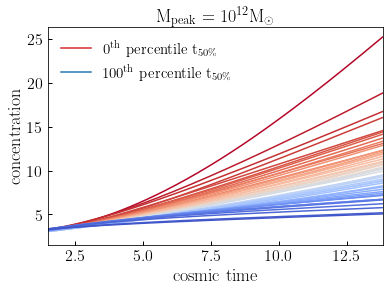

In [11]:
import matplotlib.cm as cm
from matplotlib import lines as mlines

mmsk = np.abs(halos['logmp'] - 12.0) < 0.05
sample = halos[mmsk]

n_pbins = 50
pbins = np.linspace(0, 1, n_pbins)
pmids = 0.5*(pbins[:-1] + pbins[1:])
colormap_seq=np.linspace(1,0,n_pbins)
colors=cm.coolwarm(colormap_seq)

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(1.5, 13.8)
for plo, phi, c in zip(pbins[:-1], pbins[1:], colors):
    pmsk = (sample['p_tform_50'] >= plo) & (sample['p_tform_50'] < phi)
    __=ax.plot(t_bpl, np.mean(sample['conch_fit'][pmsk], axis=0), color=c)

xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
ylabel = ax.set_ylabel(r'${\rm concentration}$')
title = ax.set_title(r'${\rm M_{\rm peak}=10^{12}M_{\odot}}$')

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm 0^{\rm th}\ percentile\ t_{50\%}}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm 100^{\rm th}\ percentile\ t_{50\%}}$')
leg=ax.legend(handles=[red_line, blue_line])
fig.savefig('concentration_history_vs_tform_logmp_12.0.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

### Study how each concentration parameter depends on the $t_{\rm form}$ percentile

In [12]:
from scipy.stats import binned_statistic

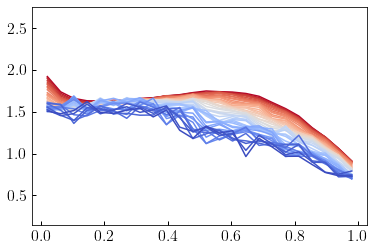

In [13]:
n_mbins = 50
lgmbins = np.linspace(11.5, 14, n_mbins)
colormap_seq=np.linspace(1,0,n_mbins)
colors=cm.coolwarm(colormap_seq)

n_pbins = 25
pbins = np.linspace(0, 1, n_pbins)
pmids = 0.5*(pbins[:-1] + pbins[1:])

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.15, 2.75)

for lgmp_sample, c in zip(lgmbins, colors):
    mmsk = np.abs(halos['logmp'] - lgmp_sample) < 0.2
    sample = halos[mmsk]

    mean_conc_beta_late, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_beta_late'], bins=pbins, statistic='mean')
    __=ax.plot(pmids, mean_conc_beta_late, color=c)


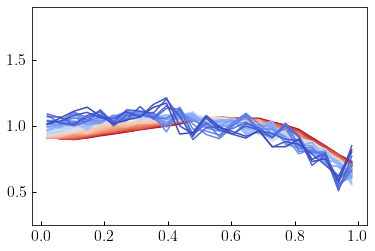

In [14]:
n_mbins = 50
lgmbins = np.linspace(11.5, 14, n_mbins)
colormap_seq=np.linspace(1,0,n_mbins)
colors=cm.coolwarm(colormap_seq)

n_pbins = 25
pbins = np.linspace(0, 1, n_pbins)
pmids = 0.5*(pbins[:-1] + pbins[1:])

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.25, 1.9)

for lgmp_sample, c in zip(lgmbins, colors):
    mmsk = np.abs(halos['logmp'] - lgmp_sample) < 0.2
    sample = halos[mmsk]

    mean_conc_lgtc, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_lgtc'], bins=pbins, statistic='mean')
    __=ax.plot(pmids, mean_conc_lgtc, color=c)


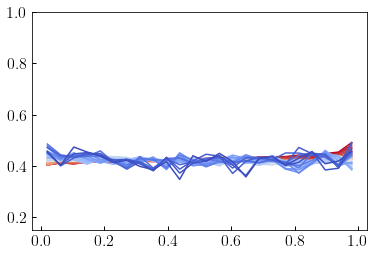

In [15]:
n_mbins = 50
lgmbins = np.linspace(11.5, 14, n_mbins)
colormap_seq=np.linspace(1,0,n_mbins)
colors=cm.coolwarm(colormap_seq)

n_pbins = 25
pbins = np.linspace(0, 1, n_pbins)
pmids = 0.5*(pbins[:-1] + pbins[1:])

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.15, 1.)

for lgmp_sample, c in zip(lgmbins, colors):
    mmsk = np.abs(halos['logmp'] - lgmp_sample) < 0.2
    sample = halos[mmsk]

    mean_conc_beta_early, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_beta_early'], bins=pbins, statistic='mean')
    __=ax.plot(pmids, mean_conc_beta_early, color=c)


### Now make a unified 3-panel summary plot

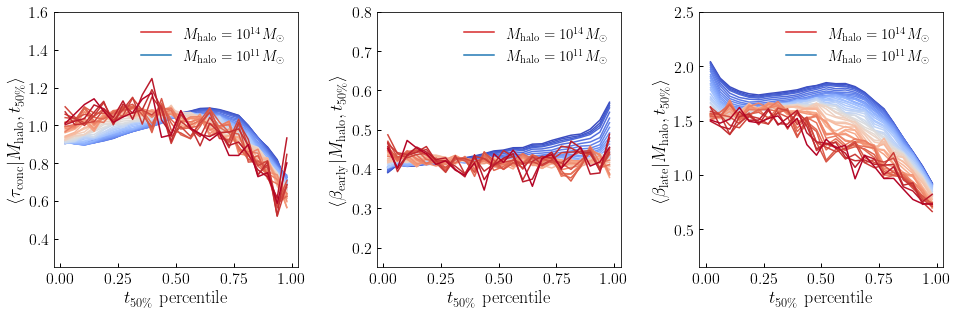

In [16]:
n_mbins = 50
lgmbins = np.linspace(11., 14, n_mbins)
colormap_seq=np.linspace(0, 1, n_mbins)
colors=cm.coolwarm(colormap_seq)

n_pbins = 25
pbins = np.linspace(0, 1, n_pbins)
pmids = 0.5*(pbins[:-1] + pbins[1:])

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 5), sharex=True)
fig.tight_layout(pad=4.0)
ylim = ax0.set_ylim(0.25, 1.6)
ylim = ax1.set_ylim(0.15, 0.8)
ylim = ax2.set_ylim(0.15, 2.5)


for lgmp_sample, c in zip(lgmbins, colors):
    mmsk = np.abs(halos['logmp'] - lgmp_sample) < 0.2
    sample = halos[mmsk]

    mean_conc_lgtc, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_lgtc'], bins=pbins, statistic='mean')
    __=ax0.plot(pmids, mean_conc_lgtc, color=c)

    mean_conc_beta_early, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_beta_early'], bins=pbins, statistic='mean')
    __=ax1.plot(pmids, mean_conc_beta_early, color=c)

    mean_conc_beta_late, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_beta_late'], bins=pbins, statistic='mean')
    __=ax2.plot(pmids, mean_conc_beta_late, color=c)


red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm halo}=10^{14}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm halo}=10^{11}M_{\odot}$')

for ax in ax0, ax1, ax2:
    xlabel = ax.set_xlabel(r'$t_{50\%}\ {\rm percentile}$')
    leg=ax.legend(handles=[red_line, blue_line])

ylabel = ax0.set_ylabel(r'$\langle\tau_{\rm conc}\vert M_{\rm halo}, t_{50\%}\rangle$')
ylabel = ax1.set_ylabel(r'$\langle\beta_{\rm early}\vert M_{\rm halo}, t_{50\%}\rangle$')
ylabel = ax2.set_ylabel(r'$\langle\beta_{\rm late}\vert M_{\rm halo}, t_{50\%}\rangle$')

fig.savefig('t_form_conc_param_dependence.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

## Develop analytic model that incorporates $t_{\rm form}$-dependence

Before proceeding to extend your existing work on the population-level model, let's quickly review the current status and big-picture goals. Currently, you have built a population-level model generates a realistic distribution of $P({\rm conc}\vert t, M_0),$ where "realistic" is quantified by the mean and variance of this PDF across time. The foundation of your model is an individual trajectory of concentration vs. time that is specified by 3 parameters, $\tau_{\rm c}, \beta_{\rm early},$ and $\beta_{\rm late}.$ For each of these three parameters, you have calibrated a fitting function for its $M_0$-dependence, $\tau_{\rm c}(M_0), \beta_{\rm early}(M_0),$ and $\beta_{\rm late}(M_0).$ The plots in this notebook show that even at fixed $M_0,$ there is quite a strong dependence of $\langle{\rm conc}\vert t\rangle$ upon the additional diffmah parameters (well, at least upon $\tau_{\rm form}$). So our new goal is to extend what you have already done to account for this additional MAH dependence.

In principle, what we _really_ want to do is build a model for the full probability distribution, $P({\rm conc}\vert t, M_0, \tau_{\rm m}, \alpha_{\rm early}, \alpha_{\rm late}),$ since that would capture the evolutionary history of halo concentration for any halo that is well-described by the 3 diffmah parameters, $\tau_{\rm m}, \alpha_{\rm early}, \alpha_{\rm late}.$ In order to do this, in principle what we need to do is to calibrate a model for $P(\tau_{\rm c}, \beta_{\rm early}, \beta_{\rm late}\vert M_0, \tau_{\rm m}, \alpha_{\rm early}, \alpha_{\rm late}).$ But we may be able to get away with a simplified version of this full PDF by building a model that only captures $P(\tau_{\rm c}, \beta_{\rm early}, \beta_{\rm late}\vert M_0, \tau_{50\%}).$ Since $\tau_{50\%}$ depends on all 3 diffmah parameters, then if we are lucky, then capturing the $\tau_{50\%}$ trend will be sufficiently accurate for purposes of accurately capturing the mean and variance of $P({\rm conc}\vert t, M_0, \tau_{\rm m}, \alpha_{\rm early}, \alpha_{\rm late}).$ 

One way to proceed is to build analytic fitting functions for the trends shown in the 3-panel plot above. I'll take a first stab at doing this for a single parameter to demo an approach that seems promising, and then pass the torch to you to do it properly for all 3 parameters. Notice that this is not _quite_ the same thing as what I sketched above in the previous paragraph, because the 3-panel plot actually shows how the diffprof parameters depend on the _percentile_ of $\tau_{50\%},$ rather than on $\tau_{50\%}$ itself. I have a hunch that this will be an easier way to formulate the problem, because the distribution and dynamic range of $\tau_{50\%}$ itself depends upon $M_0,$ where as the percentile distribution is always strictly uniform between 0 and 1, by definition. So in the cells below what I'll take a crack at is building a model for $\langle\tau_{\rm c}\vert M_0, p_{50\%}.$

Yet _another_ difference between what I do below and what you'll need to do is that here I'll just model how $\tau_{\rm c}$ depends on $M_0, p_{50\%}.$ But in practice, you'll want to adapt what I show below to model instead how the unbounded version of $\tau_{\rm c}$ depends on $M_0, p_{50\%}.$

Finally, I think our working assumption should be to start out this modeling extension by restricting attention to how the _mean_ values of the three diffprof parameters change with $M_0$ and $p_{50\%}.$ However, it may be the case that not only does $\langle\tau_{\rm c}\rangle$ change with $M_0$ and $p_{50\%},$ but also the _scatter_ in $tau_{\rm c}$ changes. If that ends up being the case, then we'll additionally need to model how our cholesky matrix parameters jointly depend on both $M_0$ and $p_{50\%}.$ If you look closely at Figure C2 in [the diffmah paper](https://arxiv.org/abs/2105.05859), you can see that not only do the ellipsoids shift with mass, but they also rotate, and so that's one way of seeing that I found that I needed to incorporate mass-dependence in my covariance matrix parameters. I think for purpose of getting started with this modeling extension, let's try and see how good of a job we can do by assuming $p_{50\%}$-independent Cholesky parameters.

### First collect the trends we wish to recover into an array

This just repeats the same for loop we used to calculate the data plotted in the rightmost panel above.

In [17]:
n_mbins = 50
lgmbins = np.linspace(11., 14, n_mbins)

n_pbins = 25
pbins = np.linspace(0, 1, n_pbins)

mean_lgtc_collector = []
for lgmp_sample, c in zip(lgmbins, colors):
    mmsk = np.abs(halos['logmp'] - lgmp_sample) < 0.2
    sample = halos[mmsk]

    mean_conc_lgtc, __, __ = binned_statistic(
        sample['p_tform_50'], sample['conc_lgtc'], bins=pbins, statistic='mean')
    mean_lgtc_collector.append(mean_conc_lgtc)
mean_lgtc_arr = np.array(mean_lgtc_collector)

### Experiment with a functional form

When you built the model for the $M_0$-dependence of the diffprof parameters, the basic functional form you used was a sigmoid function. A sigmoid has many nice properties that make it highly convenient for building fitting functions:
1. It has 4 degrees of freedom, and so has the same flexibility as a 4th order polynomial
2. Each parameter has a very easy-to-understand meaning, which makes it convenient to play with when doing by-eye fitting
3. The behavior is bounded across the entire real line, which prevents infinities and nans creeping in during optimization (this is in stark contrast to a 4th order polynomial)
4. Sigmoids have an analytical derivative, which makes gradient descent much smoother

Unfortunately, a sigmoid function is also monotonic, and if you look at the plot below, you'll see that this may be a problem for capturing the trend of $\tau_{\rm c}(p)$ for low-mass halos. Fortunately, there is a trick we can use that works well for curves that look like this. Whereas the curve we wish to approximate does not have monotonic behavior, we can see that its _slope_ appears to change monotonically. At low values of $p$ the slope is shallow and positive, and as $p$ increases, the slope goes to zero around $p=0.75$, and then goes to a reasonably steep negative value. In situations such as this, we can sometimes build a simple and effective fitting function that has a general form that looks like this: $$f(x) = y_0 + \mathcal{S}(x)\times(x-x_0).$$ In this equation, the function $\mathcal{S}(x)$ is just the usual sigmoid function that you are used to, and here it is serving as the slope. And the values $(x_0, y_0)$ are additional free parameters that control the overall normalization of the function, $y_0$ at some control point, $x_0.$ In the first cell below, I show how I just sort of guessed and fiddled with the parameters controlling the behavior of this approximation to convince myself it was worth pursuing, and then in the next cell, I bundled up this experimental code into an actual callable function and I show how used `scipy.optimize.curve_fit` to get a more ccurate approximation.


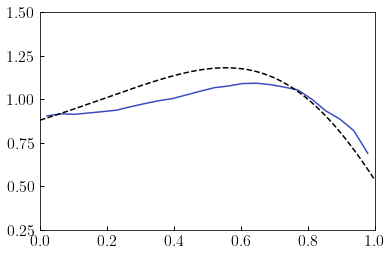

In [18]:
colormap_seq=np.linspace(0, 1, n_mbins)
colors=cm.coolwarm(colormap_seq)
pmids = 0.5*(pbins[:-1] + pbins[1:])


fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(0.25, 1.5)

lgmplot = 11.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])

p_x0, p_y0 = 0.8, 1.0
p_slope_lo, p_slope_hi, p_slope_k = 0.3, -3.5, 4.0

parr = np.linspace(0, 1, 5000)
slope = _sigmoid(parr, p_x0, p_slope_k, p_slope_lo, p_slope_hi)
lgtc_model = p_y0 + slope*(parr-p_x0)
__=ax.plot(parr, lgtc_model, '--', color='k')

In [19]:
def lgtc_vs_p_tform_model(p, pc, lgtc_pc, slope_lo, slope_hi):
    slope_k = 4.0 # Guessing in advance that we can hold this fixed
    slope = _sigmoid(p, pc, slope_k, slope_lo, slope_hi)
    return lgtc_pc + slope*(p-pc)

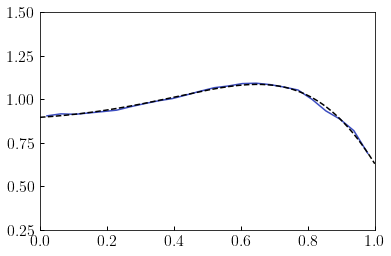

In [20]:
from scipy.optimize import curve_fit

colormap_seq=np.linspace(0, 1, n_mbins)
colors=cm.coolwarm(colormap_seq)
pmids = 0.5*(pbins[:-1] + pbins[1:])

fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(0.25, 1.5)

lgmplot = 11.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])


parr = np.linspace(0, 1, 5000)
p0=(0.85, 1.05, 0.3, -3.5)
p_opt = curve_fit(lgtc_vs_p_tform_model, pmids, mean_lgtc_arr[ilgm, :], p0=p0)[0]
__=ax.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt), '--', color='k')

### Looks great! Now let's rinse and repeat for each mass bin

Notice that within my loop over mass bins, after the initial fit, what I do is use the previous mass bin as the initial guess. This will help ensure that we get smooth $M_0$-dependence in the behavior of the best-fit parameters.


In [21]:
p0 = (0.85, 1.05, 0.3, -3.5)

p_opt_collector = []
for ilgm in range(lgmbins.size):
    xdata, ydata = pmids, mean_lgtc_arr[ilgm, :]
    p_opt = curve_fit(lgtc_vs_p_tform_model, xdata, ydata, p0=p0)[0]
    p_opt_collector.append(p_opt)
    p0 = p_opt
p_opt_arr = np.array(p_opt_collector)

### Check a couple of other mass bins to make sure the fits are actually any good

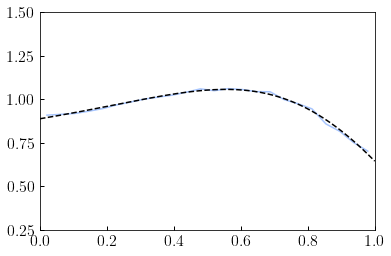

In [22]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(0.25, 1.5)

lgmplot = 12.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])


parr = np.linspace(0, 1, 5000)
__=ax.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')

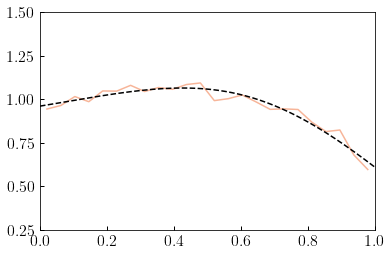

In [23]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(0.25, 1.5)

lgmplot = 13.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])


parr = np.linspace(0, 1, 5000)
__=ax.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')

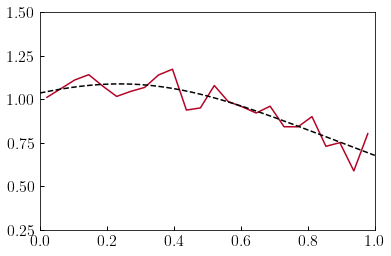

In [24]:
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0, 1)
ylim = ax.set_ylim(0.25, 1.5)

lgmplot = 14.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])


parr = np.linspace(0, 1, 5000)
__=ax.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')

### Study $M_0$-dependence of best-fit parameters

Ok so all those fits look great, so let's recap what we have achieved so far. At each mass bin, $M_0,$ we now have 4 parameters that specify the $p_{50\%}$ dependence of $\tau_{\rm c}.$ What we'll need to do now is build a model for the $M_0$-dependence. So let's look at some plots to see how our best-fit parameters depend upon $M_0.$

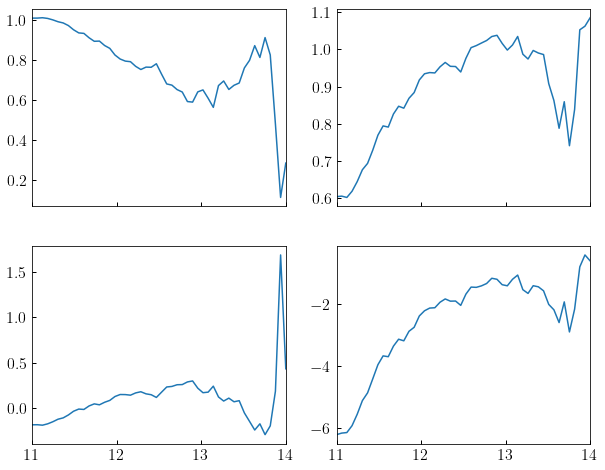

In [25]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
xlim = ax0.set_xlim(lgmbins.min(), lgmbins.max())

__=ax0.plot(lgmbins, p_opt_arr[:, 0])
__=ax1.plot(lgmbins, p_opt_arr[:, 1])
__=ax2.plot(lgmbins, p_opt_arr[:, 2])
__=ax3.plot(lgmbins, p_opt_arr[:, 3])

### Consider simplifying model

Ok, so now we're faced with the usual "art" of figuring out which of the trends are the "real" ones, and which of the bumps and wiggles are just noise that we can ignore. First of all, it looks to me from that lower left plot that the `p_slope_lo` parameter is more or less always equal to about 0.1. Of course this neglects that big spike at the highest mass, and also neglects that mild curvature, but I have hunch that if we were to hold that `p_slope_lo` fixed, that we could still get really good fits, meaning we'd have less work to do in building a model for the $M_0$-dependence.

In [26]:
def lgtc_vs_p_tform_model(p, pc, lgtc_pc, slope_hi):
    slope_k = 4.0
    slope_lo = 0.1
    slope = _sigmoid(p, pc, slope_k, slope_lo, slope_hi)
    return lgtc_pc + slope*(p-pc)

p0 = (0.85, 1.05, -3.5)

p_opt_collector = []
for ilgm in range(lgmbins.size):
    xdata, ydata = pmids, mean_lgtc_arr[ilgm, :]
    p_opt = curve_fit(lgtc_vs_p_tform_model, xdata, ydata, p0=p0)[0]
    p_opt_collector.append(p_opt)
    p0 = p_opt
p_opt_arr = np.array(p_opt_collector)

### Check a few mass bins to make sure the fits of the simpler model are still good

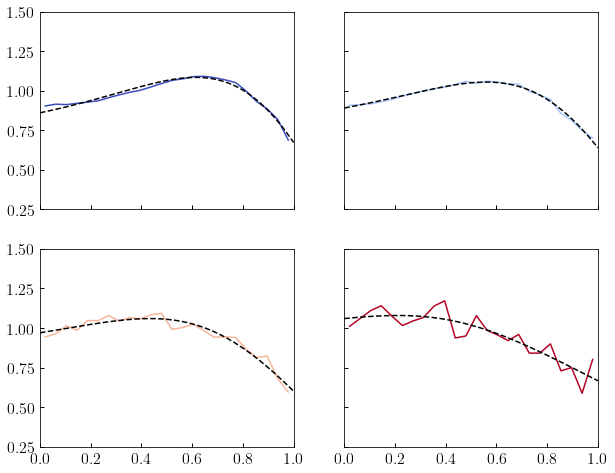

In [27]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
xlim = ax0.set_xlim(0, 1)
ylim = ax0.set_ylim(0.25, 1.5)

parr = np.linspace(0, 1, 5000)

lgmplot = 11.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax0.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])
__=ax0.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')

lgmplot = 12.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax1.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])
__=ax1.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')

lgmplot = 13.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax2.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])
__=ax2.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')

lgmplot = 14.
ilgm = np.argmin(np.abs(lgmbins-lgmplot))
__=ax3.plot(pmids, mean_lgtc_arr[ilgm, :], color=colors[ilgm])
__=ax3.plot(parr, lgtc_vs_p_tform_model(parr, *p_opt_arr[ilgm, :]), '--', color='k')


### Study $M_0$-dependence of best-fit parameters

Those fits still look great, so now let's look again at the $M_0$-dependence that we'll need to model.

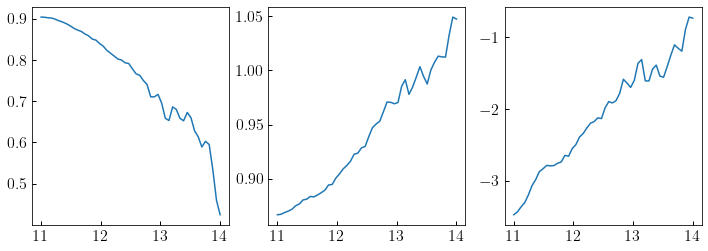

In [28]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
__=ax0.plot(lgmbins, p_opt_arr[:, 0])
__=ax1.plot(lgmbins, p_opt_arr[:, 1])
__=ax2.plot(lgmbins, p_opt_arr[:, 2])

### Not too bad!

These trends look easy to model, so it looks like our hunch at fixing `p_slope_lo` was worth doing. Let's try and capture these basic trends with, you guessed it, a sigmoid. For now we'll just hand-tune these sigmoids to get us in the ballpark.

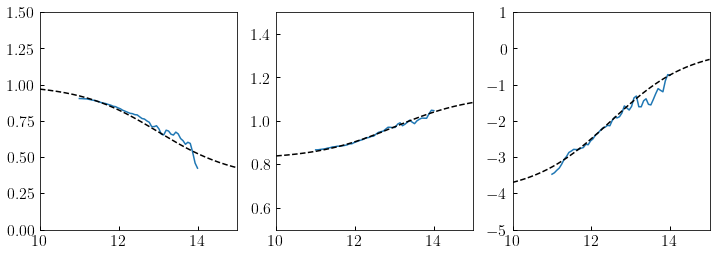

In [29]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
xlim = ax0.set_xlim(10, 15)
lgmarr = np.linspace(5, 20, 5000)

ylim = ax0.set_ylim(0, 1.5)
__=ax0.plot(lgmbins, p_opt_arr[:, 0])
__=ax0.plot(lgmarr, _sigmoid(lgmarr, 13, 1, 1, 0.35), '--', color='k')

ylim = ax1.set_ylim(0.5, 1.5)
__=ax1.plot(lgmbins, p_opt_arr[:, 1])
__=ax1.plot(lgmarr, _sigmoid(lgmarr, 13, 1, 0.825, 1.12), '--', color='k')

ylim = ax2.set_ylim(-5, 1)
__=ax2.plot(lgmbins, p_opt_arr[:, 2])
__=ax2.plot(lgmarr, _sigmoid(lgmarr, 12.5, 1, -4, 0), '--', color='k')

## Recap of what we have and what's next

Ok, so I think the above plot shows that we probably have reached "good enough for now" stage for the behavior of the following component of the population-level model: $$\langle\tau_{\rm c}\vert M_0, p_{50\%}\rangle.$$ Remember my comment from above that this is not _actually_ what we need, since this should have been instead formulated in terms of the unbounded version of $\tau_{\rm c},$ rather than $\tau_{\rm c}$ itself, but I think that much should be an easy change. So once the above exercise has been redone for the unbounded version of $\tau_{\rm c}$, the next step will be to rinse and repeat to build models for $$\langle\beta_{\rm early}\vert M_0, p_{50\%}\rangle,$$ and also $$\langle\beta_{\rm late}\vert M_0, p_{50\%}\rangle.$$

To describe the next steps more quantitatively, let me introduce a little bit of notation. Once you have redone the first step using the unbounded version of $tau_{\rm c},$ you will have (somewhat coarsely) calibrated the parameters a fitting function, $$\mathcal{F}_{\tau_{\rm c}}(M_0, p_{50\%}\vert\theta_{\tau_{\rm c}})\equiv\langle\tau_{\rm c}\vert M_0, p_{50\%}\rangle.$$ In other words, all the hand-tuning I did in the cells above at the end of the day gave us a collection of parameters, $\theta_{\tau_{\rm c}},$ together with the associated functional forms, $\mathcal{F}_{\tau_{\rm c}}.$ Once you rinse and repeat this exercise for $\beta_{\rm early}$ and $\beta_{\rm late},$ you will have developed two new functions, $\mathcal{F}_{\beta_{\rm early}}$ and $\mathcal{F}_{\beta_{\rm late}},$ and two new (again, coarsely calibrated) sets of parameters, $\theta_{\beta_{\rm early}}$ and $\theta_{\beta_{\rm late}}.$ That will be a fair amount of work, and I do not know in advance what the behavior of the functions $\mathcal{F}_{\beta_{\rm early}}$ and $\mathcal{F}_{\beta_{\rm late}}$ will be, but hopefully some collection of the modeling tools you have learned so far will be enough to build what is needed. 

By the time you have reached this point of progress in the project, you will already built a model for the $M_0$-dependence of the log-normal scatter, $\sigma(\beta_{\rm early}),$ and also a model for the Cholesky matrix governing the 2d Gaussian model for the distribution of $\tau_{\rm c}-\beta_{\rm late}.$ Let's denote the collection of parameters that control these ingredients as $\theta_{\sigma}.$ So this means that the entirety of your population-level model is regulated by the following collection of parameters: $\{\theta_{\tau_{\rm c}}, \theta_{\beta_{\rm early}}, \theta_{\beta_{\rm late}}, \theta_{\sigma}\}.$ For shorthand convenience, let's just refer to this collection with the variable $\theta.$

With this notation, you now have a parameterization that fully specifies a full-stop population-level model for the distribution of halo concentrations across time:$$P({\rm conc}\vert t, M_0, \alpha_{\rm early}, \alpha_{\rm late}, \tau_{\rm m}).$$ The way you have characterized this model is via the following distribution:$$P(\tau_{\rm c}, \beta_{\rm early}, \beta_{\rm late}\vert M_0, p_{50\%})=P(\tau_{\rm c}, \beta_{\rm early}, \beta_{\rm late}\vert\theta).$$ Thus for any particular value of $\theta$ in the parameter space of your population-level model, you can calculate $P({\rm conc}\vert t, M_0, \alpha_{\rm early}, \alpha_{\rm late}, \tau_{\rm m}).$ 

The final phase of the project is to optimize the parameters, $\theta,$ so that we accurately match some target data for the mean and variance of this distribution across time. Before now, the target data you have been using was the mean and variance of $P({\rm conc}\vert M_0, t),$ which you pre-tabulated at a collection of control points in mass, 11.5, 11.75, ..., 14.5. In order to optimize the parameters $\theta$ in this (now larger) parameter space, you will want to again pre-tabulate your target data, only this time your target data will account for the $t_{50\%}$-dependence of ${\rm conc}(t).$

The figure below shows an example of some of the target data that you will use to optimize the parameters, $\theta.$

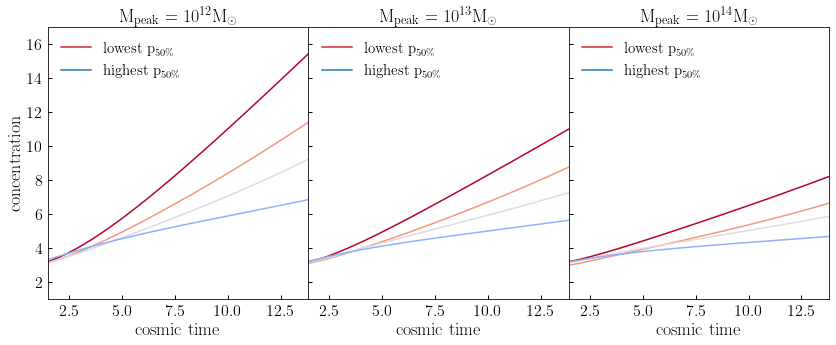

In [30]:
import matplotlib.cm as cm
from matplotlib import lines as mlines

n_pbins = 5
pbins = np.linspace(0, 1, n_pbins)
pmids = 0.5*(pbins[:-1] + pbins[1:])
colormap_seq=np.linspace(1,0,n_pbins)
colors=cm.coolwarm(colormap_seq)

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'${\rm lowest\ p_{50\%}}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'${\rm highest\ p_{50\%}}$')

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
axes = ax0, ax1, ax2
fig.subplots_adjust(wspace=0)

for ax in axes:
    xlim = ax.set_xlim(1.5, 13.8)
    xlim = ax.set_ylim(1, 17)
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time}$')
ylabel = ax0.set_ylabel(r'${\rm concentration}$')


for ax, lgm in zip(axes, (12, 13, 14)):
    mmsk = np.abs(halos['logmp'] - lgm) < 0.25
    sample = halos[mmsk]

    for plo, phi, c in zip(pbins[:-1], pbins[1:], colors):
        pmsk = (sample['p_tform_50'] >= plo) & (sample['p_tform_50'] < phi)
        __=ax.plot(t_bpl, np.mean(sample['conch_fit'][pmsk], axis=0), color=c)


for ax in axes:
    leg=ax.legend(handles=[red_line, blue_line], loc='upper left')

title = ax0.set_title(r'${\rm M_{\rm peak}=10^{12}M_{\odot}}$')
title = ax1.set_title(r'${\rm M_{\rm peak}=10^{13}M_{\odot}}$')
title = ax2.set_title(r'${\rm M_{\rm peak}=10^{14}M_{\odot}}$')


### Choosing the right target data

One unwanted complication is that the target data in this larger space may end up being pretty complicated. For example, try fiddling around with the plot above and you will see that sometimes the percentile-dependence shows some non-monotonic behavior. An easy way to recreate this is to just choose a very narrow bin of ${\rm d}\log_{10}M_{\rm halo}$, and the noise that results from the smaller sample will give you colored curves that cross each other. This is likely to be unphysical, but unfortunately we may have built a model with sufficient flexibility that actually has capability to reproduce the unphysical crossing, which of course we do not want. And so this means we need to be very careful about how we choose our target data. 

First of all, we'll need to make sure we have good statistics in all the bins we choose in order to avoid this situation. But it may be the case that we end up needing to do something a little more involved. One thing I have done in previous projects is to actually build an entirely separate fitting function for the target data itself, for example a smooth curve that has been tuned to go through each of the curves of the target data, but without any unwanted crossings, by design. Then for my target data I use the approximating function, rather than the noisy target data.

Is this crazy? Well, it's a little bit crazy. After all, if we had a fitting function for the target data, why not just use that all along? But this target-data fitting function is entirely unphysical and has no reference at all to halo properties, it just literally and directly describes the curves in the above plot (such as a separate sigmoid function in each bin of target data, something like that). Whereas the model $\theta$ actually describes something physical: the PDF of halo concentration trajectories across time. And so it's not really crazy, it's just more work. Anyway, we can cross this bridge when we come to it.

I have a hunch that we'll want to fit our model using $M_0$-bins that are logarithmically spaced 0.5dex apart and are each $0.25$dex in width, and that within each $M_0$ bin, we'll want to fit 4 quartiles for the $p_{50\%}$-dependence. And for the scatter, I also have a hunch that we'll have better luck fitting the variance _only_ conditioned upon $M_0,$ and _not_ fitting for the $p_{50\%}$-dependence within each mass bin. But this is something that we'll just have to play with when we get to this part of the project.